# 15대 젠더 관련 의안 분석

### 1996.05.30 ~ 2000.05.29 / 김영삼, 김대중 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
bill_df1 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/15대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'])
bill_df2 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/15대 국회 의안정보(2).csv', 
                      parse_dates=['제안일자', '의결일자'])

bill_df = pd.concat([bill_df1, bill_df2]).drop_duplicates()
bill_df.shape

(1951, 10)

In [4]:
def preprocessing(text): 
    text = text.replace('■ 제안이유', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ')
    text = text.replace('■ 위원회 수정사항□ 수정이유',' ').replace('■ 제안경위',' ').replace('[',' ').replace(']',' ')
    text = text.replace('녀성', '여성').replace('로동', '노동').replace('륜리','윤리').replace('녀비','여비')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('및','').replace('주요골자', ' ').replace('■ 수정사항',' ')
    text = text.replace('"',' ').replace('륜락', '윤락')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [5]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: hanja.translate(x, 'substitution'))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 4.85 s, sys: 27.2 ms, total: 4.88 s
Wall time: 4.9 s
CPU times: user 25.7 ms, sys: 1.36 ms, total: 27 ms
Wall time: 27.2 ms
CPU times: user 1.58 ms, sys: 78 µs, total: 1.66 ms
Wall time: 1.63 ms


In [6]:
bill_df.head(1)

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,152569,미용사법안,2000-02-24,의원,2000-05-29,임기만료폐기,제15대 (1996~2000) 제210회,"과거의 理·미용사법(1961년 제정)과 공중위생법(1986년 제정), 그리고 ...",보건복지위원회,"['조성준', '김영구', '김영배', '김진배', '김형오', '박관용', '박구..."


## 젠더 관련 의안만 추리기

In [7]:
# 딱히 특정할만한 소관위원회는 없음 
bill_df['소관위원회'].unique()

array(['보건복지위원회', '행정자치위원회', '국회운영위원회', '환경노동위원회', '정무위원회', '농림해양수산위원회',
       '재정경제위원회', '건설교통위원회', '과학기술정보통신위원회', '교육위원회', '법제사법위원회', '산업자원위원회',
       '통일외교통상위원회', '문화관광위원회', '국방위원회', '정보위원회', '2002년월드컵등국제경기대회지원특별위원회',
       '행정위원회', '통일외무위원회', '내무위원회', '정치개혁입법특별위원회', '통상산업위원회', '통신과학기술위원회',
       '문화체육공보위원회', '제도개선특별위원회'], dtype=object)

In [8]:
keyword = r'.*(여성|성범죄|남녀|호주|육아|보육|가부장|강간|간통죄|정조|성폭력|남녀평등|성차별|모성|성접대|낙태|부녀자|퇴폐|남여|미혼모|\
                성희롱|성보호|음란|가족|윤락|위안부|양성평등|양성 평등|스토킹|가정폭력|정신대|청소년|가정폭력|남녀차별|모자보건|출산).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(239, 10)

In [9]:
gender[gender['의안번호'] == 150087]

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
236,150087,영유아보육법중개정법률안,1996-08-31,의원,1999-01-06,대안반영폐기,제15대 (1996~2000) 제181회,상유아보육시설의 설치 운영등 상유아의 보육사업에 소요되는 비용의 일부를...,보건복지위원회,"['김홍일', '김영진', '김옥두', '김인곤', '김진배', '남궁진', '류재..."


In [10]:
for ind in range(len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '제안이유'])

152556
   국정감사  조사의 효율성을 제고하기 위하여 국회운영위원회의 조정기능을 강화하고, 국정조사의 실시요건을완화하며, 또한 국정조사의 실효성을 제고하는 등 국정감사  조사의 절차와 방법을 개선·보완하려는 것임. 1. 국회운영위원회는 상임위원회간에 감사대상기관이나 감사일정 등이 중복될 때에는 이를 조정할 수 있도록함(안 제2조제2항).2. 국회는 재적의원 4분의 1 이상의 요구가 있는 때에는 특별위원회 또는 상임위원회로 하여금 국정의 특정사안에 관하여 조사를 시행할 수 있도록 함(안 제3조).3. 감사 또는 조사를 행하는 위원회는 상설소위원회로 하여금 감사 또는 조사를 시행하게 할 수 있도록 함(안제5조제1항).4. 지방자치단체에 대한 국정감사는 2이상의 위원회가 합동으로 반을 구성하여 시행할 수 있도록 함(안 제7조의2).5. 위원회는 국정조사를 하기 전에 전문위원 기타 국회사무처 소속직원이나 조사대상기관의 소속이 아닌 전문가 등으로 하여금 예비조사를 하게 할 수 있도록 함(안 제9조의2).6. 본회의 또는 위원회는 국정조사기간  자료의 부족 등으로 인하여 조사가 추가로 필요하다고 인정되는 경우나 사전조사가 필요한 경우에는 그 의결로 감사원 등 관계행정기관의 장에게 인력 등의 지원을 요청할수 있도록 하고, 이 경우 관계행정기관의 장은 특별한 사유가 없는 한 이에 응하도록 함(안 제15조의2).  
152550
   1. 1999년 11월 4일 박상천·林채정·정세균·방용석의원외 101인이 발의한 아동·청소년의성보호에관한법률안이 같은 해 11월 5일 우리 위원회에 회부되어 이를 제208회국회(정기회) 제6차 정무위원회( 99.11.23)에상정하여 제안설명, 검토보고를 듣고 대체토론을 거친 후 법안심사소위원회에 회부하였음.2. 1999년 11월 5일 권영자·금영선의원외 130인이 발의한 청소년보호법중개정법률안이 같은 해 11월 9일 우리 위원회에 회부되어 이를 제208회국회(정기회) 제6차 정무위원회( 99.11.23)에 상정하여 제안설명, 검토보고를 듣

In [11]:
remove_bill = [152556, 152531, 152502, 152472, 152485, 152458, 152454, 152444, 152427, 152426, 152414, 152360, 
               152342, 152339, 152316, 152281, 152277, 152216, 152193, 152190, 152147, 152135, 152125, 152074, 
               152072, 152025, 152023, 151996, 151975, 151964, 151937, 151917, 151904, 151848, 151846, 151842, 
               151824, 151815, 151788, 151760, 151747, 151742, 151741, 151609, 151608, 151607, 151606, 151605, 
               151604, 151603, 151602, 151601, 151600, 151586, 151585, 151583, 151576, 151573, 151566, 151565, 
               151556, 151554, 151540, 151539, 151538, 151537, 151521, 151512, 151506, 151505, 151502, 151493, 
               151474, 151463, 151408, 151407, 151405, 151381, 151379, 151338, 151301, 151291, 151249, 151215, 
               151211, 151168, 151160, 151156, 151145, 151116, 151051, 151028, 151023, 150951, 150946, 150938, 
               150916, 150905, 150898, 150873, 150846, 150844, 150843, 150835, 150834, 150830, 150829, 150825,
               150776, 150759, 150747, 150744, 150742, 150660, 150659, 150648, 150638, 150632, 150609, 150608, 
               150605, 150604, 150594, 150587, 150565, 150560, 150547, 150539, 150538, 150531, 150530, 150522, 
               150416, 150410, 150409, 150408, 150391, 150381, 150377, 150373, 150311, 150310, 150305, 150285, 
               150265, 150259, 150255, 150235, 150220, 150210, 150187, 150186, 150166, 150155, 150152, 150002]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(83, 10)

In [12]:
len(remove_bill)

156

In [13]:
gender

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,152550,청소년의성보호에관한법률안,2000-01-13,위원장,2000-01-14,원안가결,제15대 (1996~2000) 제209회,1. 1999년 11월 4일 박상천·林채정·정세균·방용석의원외 101인이 발의...,정무위원회,[]
1,152499,사립학교법중개정법률안,1999-12-17,위원장,1999-12-28,원안가결,제15대 (1996~2000) 제209회,1. 1999년 9월 10일 李미경의원외 23인이 발의하여 동일 우리 위원회에...,교육위원회,[]
2,152498,교육공무원법중개정법률안,1999-12-17,위원장,1999-12-28,원안가결,제15대 (1996~2000) 제209회,1. 1999년 8월 16일 李미경의원외 23인이 발의하여 동년 9월 10일 ...,교육위원회,[]
3,152488,남녀고용평등법중개정법률안,1999-12-16,의원,2000-05-29,임기만료폐기,제15대 (1996~2000) 제208회,현재 무급인 육아휴직기간의 소득보장을 위하여 고용보험법에서 임金의 일부를 지급...,환경노동위원회,"['김정숙', '권영자', '김영선', '김영환', '김칠환', '박근혜', '박범..."
4,152486,국민건강보험법중개정법률안,1999-12-16,의원,2000-05-29,임기만료폐기,제15대 (1996~2000) 제208회,여성의 모성기능 보호의 일환으로 임산부가 태아건강검진을 받고 산전후 휴식을 취...,보건복지위원회,"['김정숙', '권영자', '김영선', '김영환', '김칠환', '박근혜', '박범..."
...,...,...,...,...,...,...,...,...,...,...
78,150193,가정폭력방지법안,1996-10-30,의원,1997-11-17,대안반영폐기,제15대 (1996~2000) 제181회,그동안 가정폭력이 가정내의 문제로만 치부되어 사회적으로 방관·조장되어 왔다. ...,법제사법위원회,"['신낙균', '김한길', '이성재', '이해찬', '정희경', '추미애', '한영..."
79,150192,성폭력범죄의처벌및피해자보호등에관한법률중개정법률안,1996-10-30,의원,1997-07-30,대안반영폐기,제15대 (1996~2000) 제181회,현행「성폭력범죄의처벌피해자보호등에관한법률」이 시행된지 2년이 지났음에도 불구하...,법제사법위원회,"['신낙균', '김한길', '박상천', '박상천', '이성재', '이해찬', '정희..."
80,150122,상속세법개정법률안,1996-10-02,정부,1996-12-13,원안가결,제15대 (1996~2000) 제181회,"1950년에 상속세법이 제정된 이후, 그동안 소득수준의 향상, 인구의 노령화,...",재정경제위원회,[]
81,150087,영유아보육법중개정법률안,1996-08-31,의원,1999-01-06,대안반영폐기,제15대 (1996~2000) 제181회,상유아보육시설의 설치 운영등 상유아의 보육사업에 소요되는 비용의 일부를...,보건복지위원회,"['김홍일', '김영진', '김옥두', '김인곤', '김진배', '남궁진', '류재..."


In [59]:
gender.to_csv('15th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [60]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [61]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [62]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 12 ms, sys: 685 µs, total: 12.7 ms
Wall time: 12.6 ms


In [63]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [64]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 20.7 s, sys: 433 ms, total: 21.2 s
Wall time: 9.65 s


0    [청소년의성보호에관한법률안, 박상천, 채정, 정세균, 방용석의원, 발의, 아동, 청...
1    [사립학교법중개정법률, 미경의원외, 발의, 우리, 위원회, 회부, 사립학교법중개정법...
2    [교육공무원법중개정법률, 미경의원외, 발의, 동년, 우리, 위원회, 회부, 교육공무...
Name: tokens, dtype: object

In [65]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 34.2 ms, sys: 1.09 ms, total: 35.3 ms
Wall time: 36.6 ms


In [66]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [67]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-14 23:22:18,284 : INFO : collecting all words and their counts
2020-09-14 23:22:18,292 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-14 23:22:18,297 : INFO : collected 3545 word types from a corpus of 11984 raw words and 83 sentences
2020-09-14 23:22:18,304 : INFO : Loading a fresh vocabulary
2020-09-14 23:22:18,310 : INFO : effective_min_count=10 retains 232 unique words (6% of original 3545, drops 3313)
2020-09-14 23:22:18,311 : INFO : effective_min_count=10 leaves 5103 word corpus (42% of original 11984, drops 6881)
2020-09-14 23:22:18,312 : INFO : deleting the raw counts dictionary of 3545 items
2020-09-14 23:22:18,319 : INFO : sample=0.001 downsamples 139 most-common words
2020-09-14 23:22:18,325 : INFO : downsampling leaves estimated 3362 word corpus (65.9% of prior 5103)
2020-09-14 23:22:18,329 : INFO : estimated required memory for 232 words and 100 dimensions: 301600 bytes
2020-09-14 23:22:18,332 : INFO : resetting layer weights
202

2020-09-14 23:22:18,677 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:18,678 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:18,679 : INFO : EPOCH - 15 : training on 11984 raw words (3356 effective words) took 0.0s, 462077 effective words/s
2020-09-14 23:22:18,685 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:18,689 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:18,690 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:18,692 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:18,693 : INFO : EPOCH - 16 : training on 11984 raw words (3389 effective words) took 0.0s, 327132 effective words/s
2020-09-14 23:22:18,700 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:18,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-09-14 23:22:18,950 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:18,952 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:18,955 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:18,958 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:18,959 : INFO : EPOCH - 32 : training on 11984 raw words (3376 effective words) took 0.0s, 268820 effective words/s
2020-09-14 23:22:18,969 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:18,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:18,973 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:18,975 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:18,977 : INFO : EPOCH - 33 : training on 11984 raw words (3422 effective words) took 0.0s, 261316 effective words/s
2020-0

2020-09-14 23:22:19,198 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,199 : INFO : EPOCH - 48 : training on 11984 raw words (3383 effective words) took 0.0s, 405255 effective words/s
2020-09-14 23:22:19,204 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,206 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,208 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,209 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,210 : INFO : EPOCH - 49 : training on 11984 raw words (3354 effective words) took 0.0s, 559305 effective words/s
2020-09-14 23:22:19,215 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,216 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,217 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-09-14 23:22:19,424 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,425 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,426 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,430 : INFO : EPOCH - 65 : training on 11984 raw words (3379 effective words) took 0.0s, 328871 effective words/s
2020-09-14 23:22:19,439 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,445 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,446 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,456 : INFO : EPOCH - 66 : training on 11984 raw words (3408 effective words) took 0.0s, 184646 effective words/s
2020-09-14 23:22:19,463 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-09-14 23:22:19,708 : INFO : EPOCH - 81 : training on 11984 raw words (3381 effective words) took 0.0s, 350325 effective words/s
2020-09-14 23:22:19,719 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,729 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,731 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,734 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,737 : INFO : EPOCH - 82 : training on 11984 raw words (3386 effective words) took 0.0s, 183279 effective words/s
2020-09-14 23:22:19,743 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,745 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,747 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,749 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-09-14 23:22:19,965 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,966 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,967 : INFO : EPOCH - 98 : training on 11984 raw words (3308 effective words) took 0.0s, 432637 effective words/s
2020-09-14 23:22:19,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,975 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:22:19,978 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:22:19,980 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:22:19,981 : INFO : EPOCH - 99 : training on 11984 raw words (3401 effective words) took 0.0s, 327905 effective words/s
2020-09-14 23:22:19,989 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:22:19,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

In [68]:
print(model.wv.most_similar('여성'))
# print(model.wv.most_similar('청소년'))

2020-09-14 23:22:20,020 : INFO : precomputing L2-norms of word weight vectors


[('도모', 0.8923960328102112), ('촉진', 0.7562986612319946), ('중소기업청장', 0.7312065362930298), ('적극적', 0.689418375492096), ('여성기업', 0.6229106187820435), ('활동', 0.6072757244110107), ('실질적', 0.5926905274391174), ('추진', 0.5793201923370361), ('개선', 0.5731437802314758), ('수립', 0.5652016401290894)]


In [69]:
gender['tokens']

0     [청소년의성보호에관한법률안, 박상천, 채정, 정세균, 방용석의원, 발의, 아동, 청...
1     [사립학교법중개정법률, 미경의원외, 발의, 우리, 위원회, 회부, 사립학교법중개정법...
2     [교육공무원법중개정법률, 미경의원외, 발의, 동년, 우리, 위원회, 회부, 교육공무...
3     [남녀고용평등법중개정법률, 육아휴직기간, 소득보장, 고용보험법, 지급, 가족간호휴직...
4     [국민건강보험법중개정법률, 여성, 모성기능, 보호, 일환, 임산부, 태아건강검진, ...
                            ...                        
78    [가정폭력방지법안, 그동안, 가정폭력, 가정내, 문제, 치부, 사회적, 방관, 조장...
79    [성폭력범죄의처벌및피해자보호등에관한법률중개정법률안, 현행, 성폭력범죄의처벌피해자보호...
80    [상속세법개정법률안, 상속세법, 제정, 이후, 그동안, 소득수준, 향상, 인구, 노...
81    [영유아보육법중개정법률, 상유아보육시설, 설치, 운영등, 상유아, 보육사업, 소요,...
82    [남녀고용평등법중개정법률, 근로자, 고용, 제반근무환경, 남녀평등, 확보, 성별등,...
Name: tokens, Length: 83, dtype: object

In [70]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [71]:
gender_word = total_tokens(gender['tokens'])

In [74]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등', '위원회','대상','회부','발의','우리','결과','결정','대안','내용','인정',
            '각종','처리','기능','한편','목적','제안','부의']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

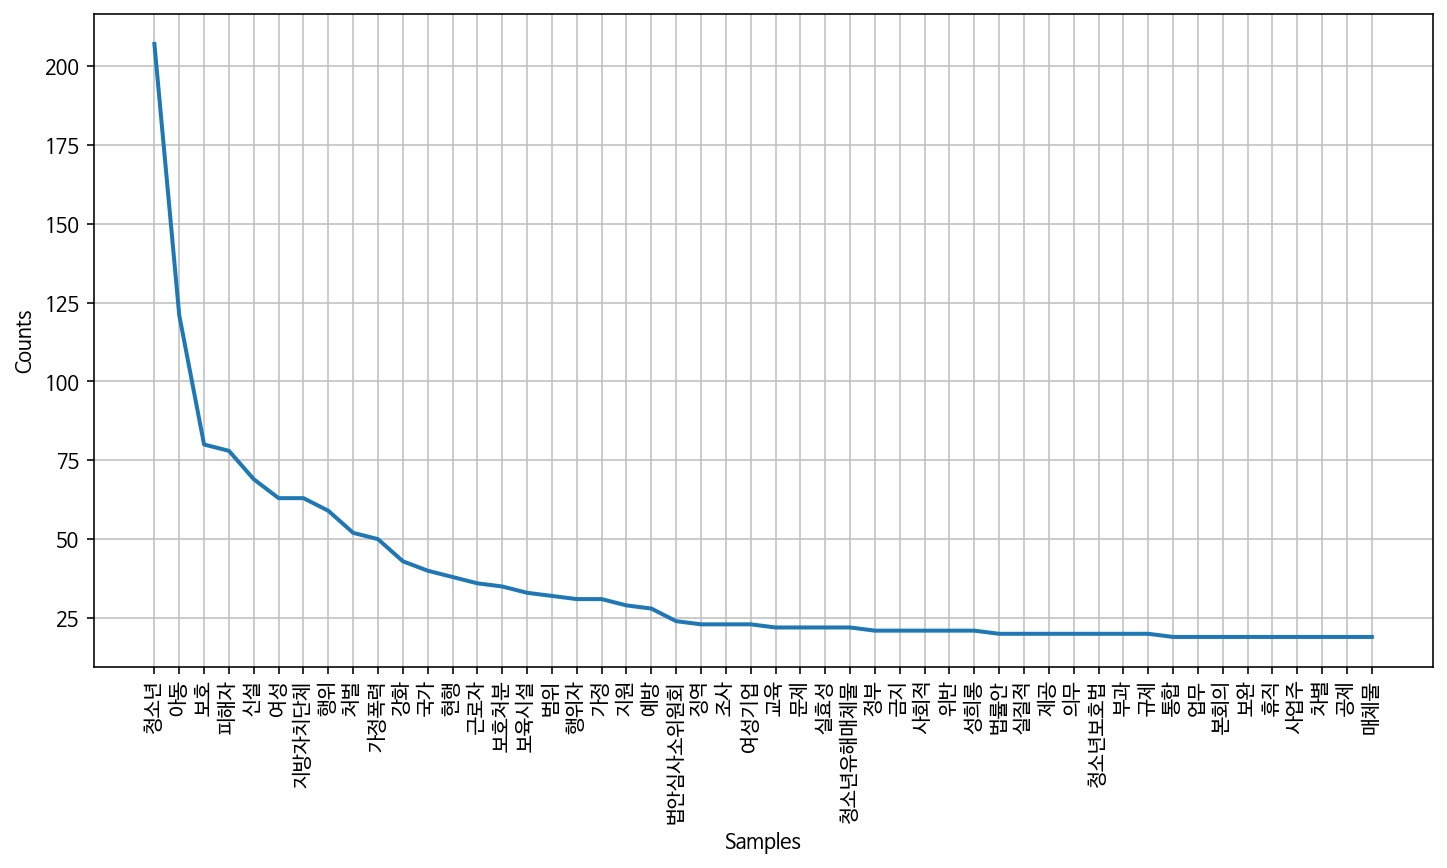

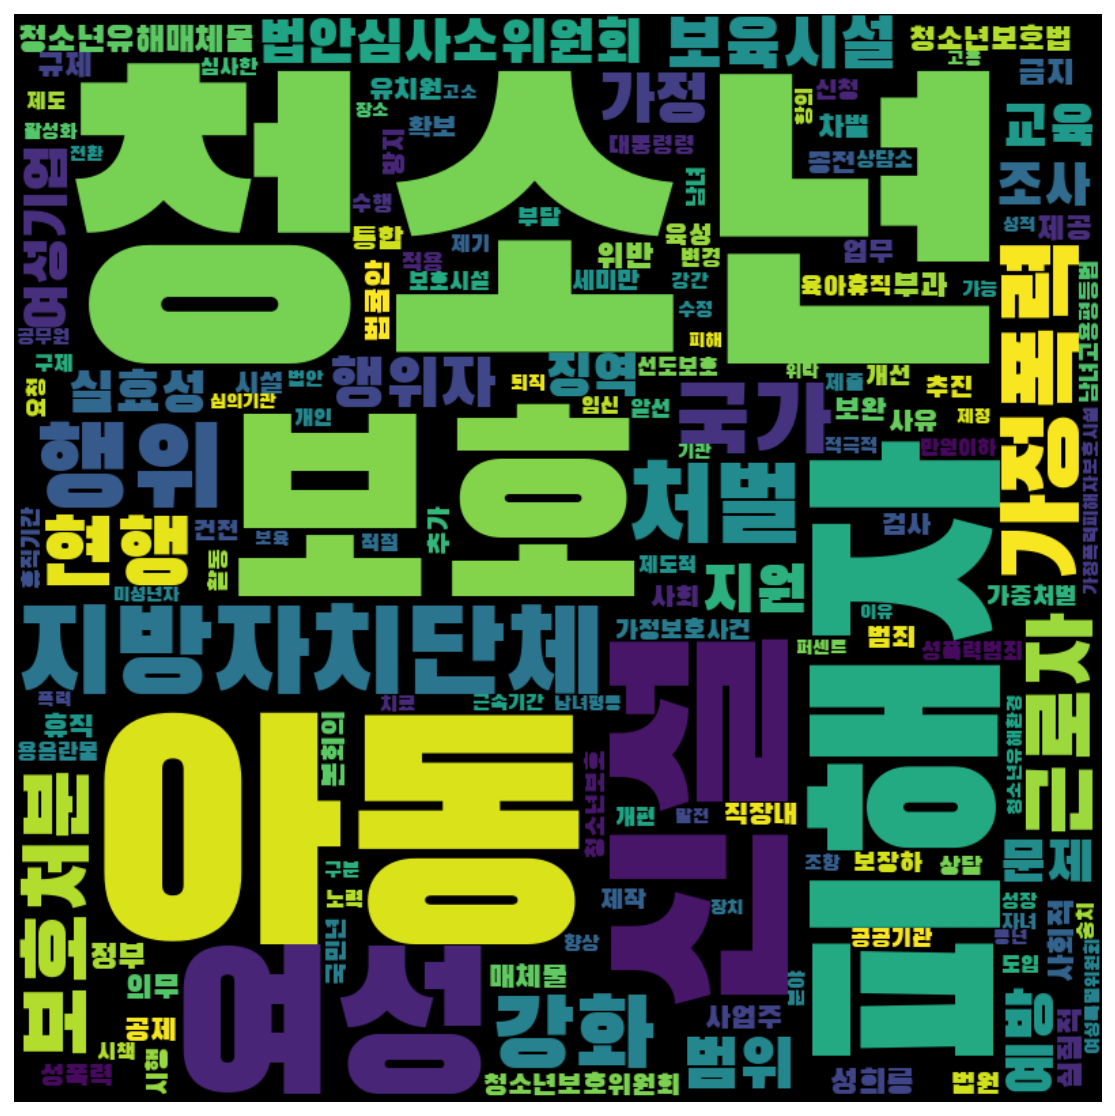

In [75]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)